In [1]:
import os
import json
import pandas as pd
import numpy as np
import sklearn
from sklearn.cluster import KMeans
from sklearn.decomposition import KernelPCA, PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

plt.rcParams['figure.figsize'] = [15, 9]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower


In [197]:
def load_investor_summary():
    files = list(os.walk("../scrapy_projects/etoro/etoro/"))[0][2]
    etoro_sum_paths = [f for f in files if f.startswith("investor_dashboard")]
    with open(f"../scrapy_projects/etoro/etoro/{ sorted(etoro_sum_paths)[-1]}","r") as f:
        etoro_investor_sum = json.load(f)
        
    return etoro_investor_sum


def load_investor_portfolio():
    files = list(os.walk("../scrapy_projects/etoro/etoro/"))[0][2]
    etoro_investor_paths = [f for f in files if f.startswith("investor_portfolio")]
    etoro_investors = []
    for path in etoro_investor_paths:
        with open(f"../scrapy_projects/etoro/etoro/{path}","r") as f:
            _ = json.load(f)
            etoro_investors.extend(_)


    investor_portfolio = []
    for investor in etoro_investors:
        for item in investor["items"]:
            row = {"investor_name":investor["investor_name"],
                        "date":investor["datetime"],
                        "company":item["company_ticker"],
                        "type":item["type"],
                        "invested":item["invested"].replace("<","").replace("%","")}
            investor_portfolio.append(row)
    return investor_portfolio



def load_marketbeat():
    files = list(os.walk("../scrapy_projects/marketbeat/marketbeat/"))[0][2]
    dashboard_files = [f for f in files if f.startswith("marketbeat_dashboard")]
    dfs = []
    
    for file_path in dashboard_files:
        file_date = file_path.split("_")[-1].split(".")[0]
        with open(f"../scrapy_projects/marketbeat/marketbeat/{file_path}",'r') as f:
            this_data = json.load(f)
            df = pd.DataFrame(this_data)
            df["date"] = file_date
            df["date"] = pd.to_datetime(df["date"],format='%d-%m-%y')
            df["overall_rank"] = df["overall_rank"].apply(lambda x: x.replace("out of 5 stars","") if x else -1)
            for col in df.columns:
                if col.endswith("rank"):
                    df[col] = df[col].astype(np.float64)
            dfs.append(df)
            
    return pd.concat(dfs)

def load_marketbeat_target():
    dfs = []
    with open(f"../scrapy_projects/marketbeat/marketbeat/marketbeat_price_target.json",'r') as f:
         _ = json.load(f)
    for stock in _:
        if len(stock["history"]) > 0:
            df = pd.DataFrame(stock["history"])
            df["symbol"] = stock["stock"]
            df["date"] = pd.to_datetime(df["Date"])
            df = df.drop(["Date","Unnamed: 6"],axis=1,inplace=False)
            dfs.append(df)
    return pd.concat(dfs)

def load_marketwatch():
    files = list(os.walk("../scrapy_projects/marketwatch/marketwatch/"))[0][2]
    files = [f for f in files if f.startswith("marketwatch")]
    
    dfs = []
    for file_path in files:
            file_date = file_path.split("_")[-1].split(".")[0]
            with open(f"../scrapy_projects/marketwatch/marketwatch/{file_path}",'r') as f:
                this_data = json.load(f)
                rows = []
                for stock in this_data:
                    row = {"date": file_date}
                    row.update({"symbol":stock["symbol"]})
                    row.update({k:v for k,v in stock["snapshot"].items()})
                    row.update({k:v for k,v in stock["price_target"].items()})
                    rows.append(row)
            df = pd.DataFrame(rows)
            df["date"] = pd.to_datetime(df["date"],format='%d-%m-%y')
            dfs.append(df)
    marketwatch_df = pd.concat(dfs)
    
    number_cols = ["High", "Median", "Low", "Average", "Current Price"]
    for col in number_cols:
        marketwatch_df[col] = marketwatch_df[col].apply(lambda x: float(x.replace("$","").replace(",","").replace('N/A',"nan")) if len(x) > 0 else -1)
    
    return marketwatch_df

def load_social_trends():
    pass



# Explore investor summary

In [3]:
investor_portfolio = load_investor_portfolio()
investor_summary = load_investor_summary()

investor_summary_df = pd.DataFrame(investor_summary)
investor_portfolio = pd.DataFrame(investor_portfolio)
investor_portfolio = investor_portfolio.astype({'invested': 'float32'})
investor_portfolio["date"] = pd.to_datetime(investor_portfolio["date"],format='%y-%m-%d')

investor_mapping = dict(zip(investor_summary_df["CustomerId"],investor_summary_df["UserName"]))
investor_summary_df = investor_summary_df.set_index(["CustomerId","UserName"])
investor_summary_df = investor_summary_df[['Gain', 'DailyGain', 'ThisWeekGain', 'RiskScore', 'MaxDailyRiskScore',
       'MaxMonthlyRiskScore', 'Copiers', 'CopyTradesPct', 'Trades', 'WinRatio',
       'DailyDD', 'WeeklyDD', 'ActiveWeeks','WeeksSinceRegistration']]

for col in investor_summary_df:
    investor_summary_df[col] = investor_summary_df[col].apply(lambda x: str(x).replace("$","").replace("+","").replace("M","")).astype(np.float32)
    
investor_summary_df.head()

,,Gain,DailyGain,ThisWeekGain,RiskScore,MaxDailyRiskScore,MaxMonthlyRiskScore,Copiers,CopyTradesPct,Trades,WinRatio,DailyDD,WeeklyDD,ActiveWeeks,WeeksSinceRegistration
CustomerId,UserName,,,,,,,,,,,,,,
5489903,rubymza,49.150002,-0.32,-1.93,4.0,6.0,5.0,18731.0,0.000000,722.0,81.994461,-4.64,-6.85,57.0,243.0
6253394,Richardstroud,65.660004,-0.13,0.60,3.0,6.0,5.0,16708.0,0.000000,84.0,70.238098,-3.98,-4.36,57.0,199.0
10633478,Social-Investor,36.700001,0.43,-0.57,3.0,6.0,4.0,5756.0,0.074906,1335.0,57.453182,-3.33,-5.81,57.0,101.0
9629091,oceantan007,57.799999,-0.93,-1.75,4.0,6.0,5.0,4593.0,0.000000,167.0,80.838326,-4.68,-5.40,53.0,138.0
6084415,CanZhao,134.119995,-2.64,1.96,4.0,7.0,5.0,3191.0,0.000000,888.0,58.445946,-4.37,-9.88,57.0,208.0


In [4]:
investor_summary_numpy = StandardScaler().fit_transform(investor_summary_df)

100%|██████████| 43/43 [00:58<00:00,  1.52s/it]


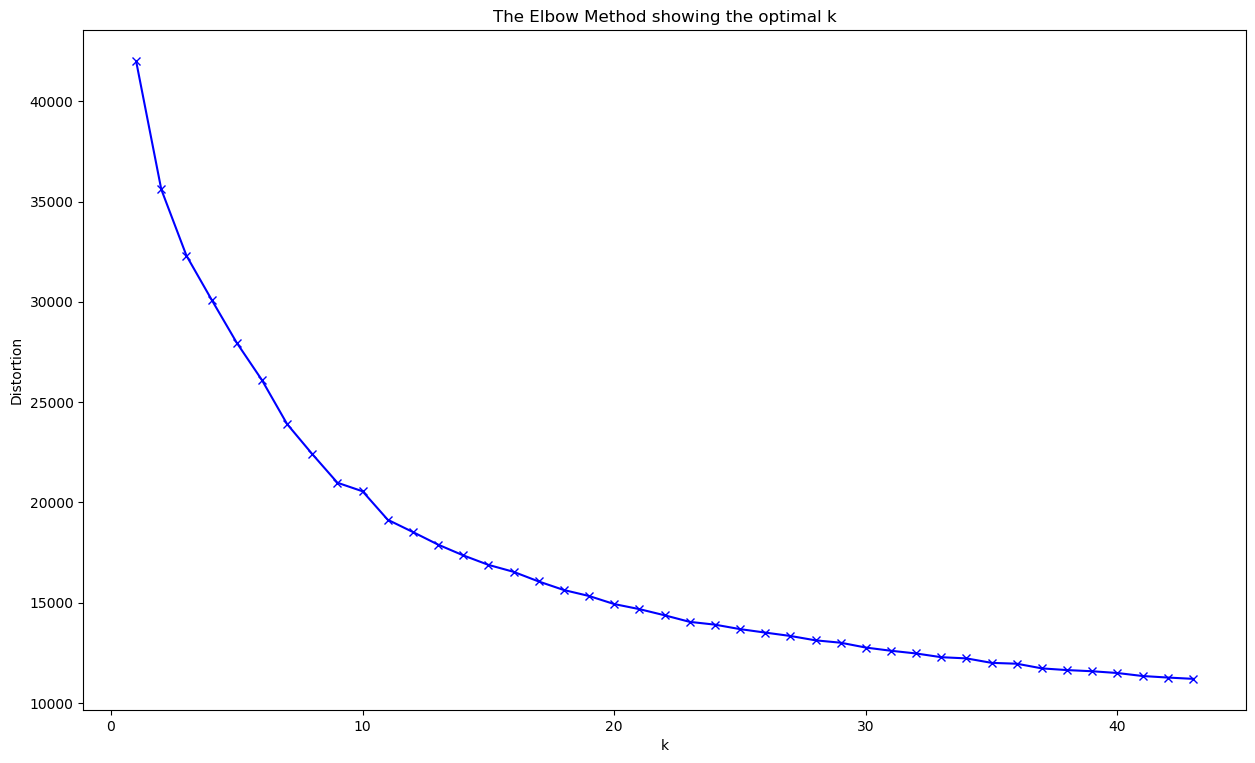

In [24]:
distortions = []
K = range(1,40)
for k in tqdm(K):
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(investor_summary_numpy)
    distortions.append(kmeanModel.inertia_)

plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [5]:
kmeans = KMeans(10)
kmeans.fit(investor_summary_numpy)
investor_summary_df["k_means_cluster"] = kmeans.predict(investor_summary_numpy)

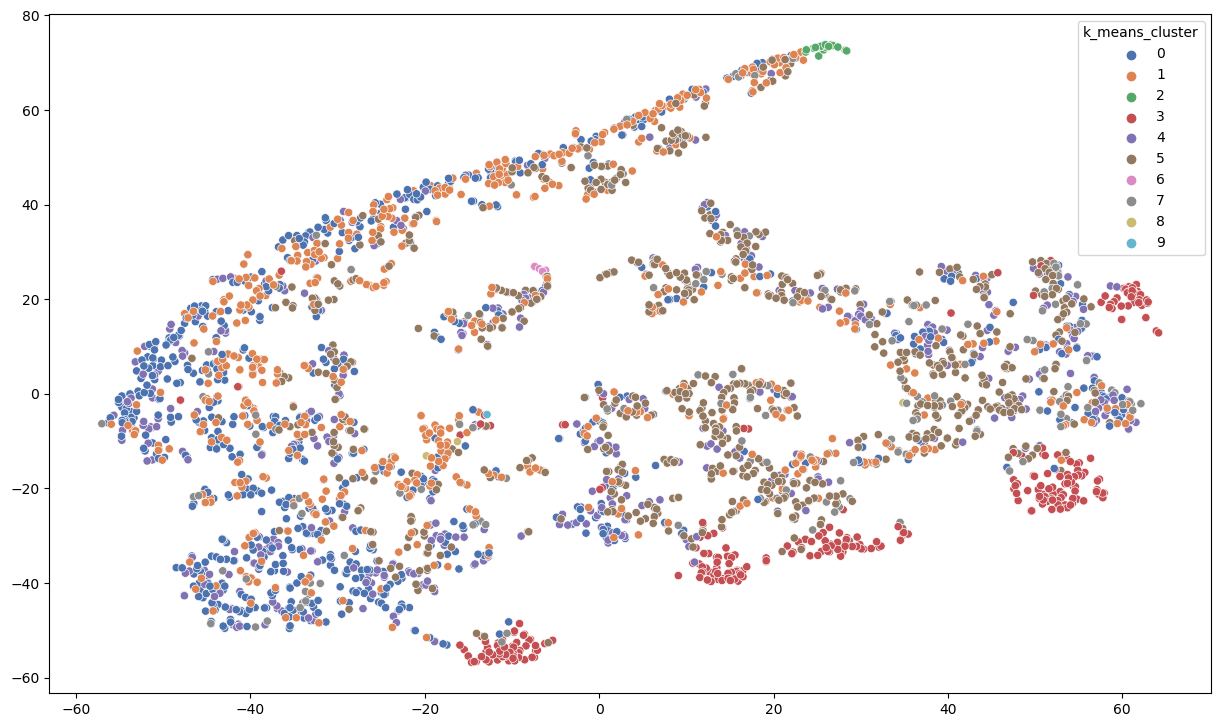

In [6]:
tsne = TSNE(n_components=2)
tsne_vals = tsne.fit_transform(investor_summary_df)

sns.scatterplot(x=tsne_vals[:,0],y=tsne_vals[:,1],hue=investor_summary_df["k_means_cluster"],palette="deep")

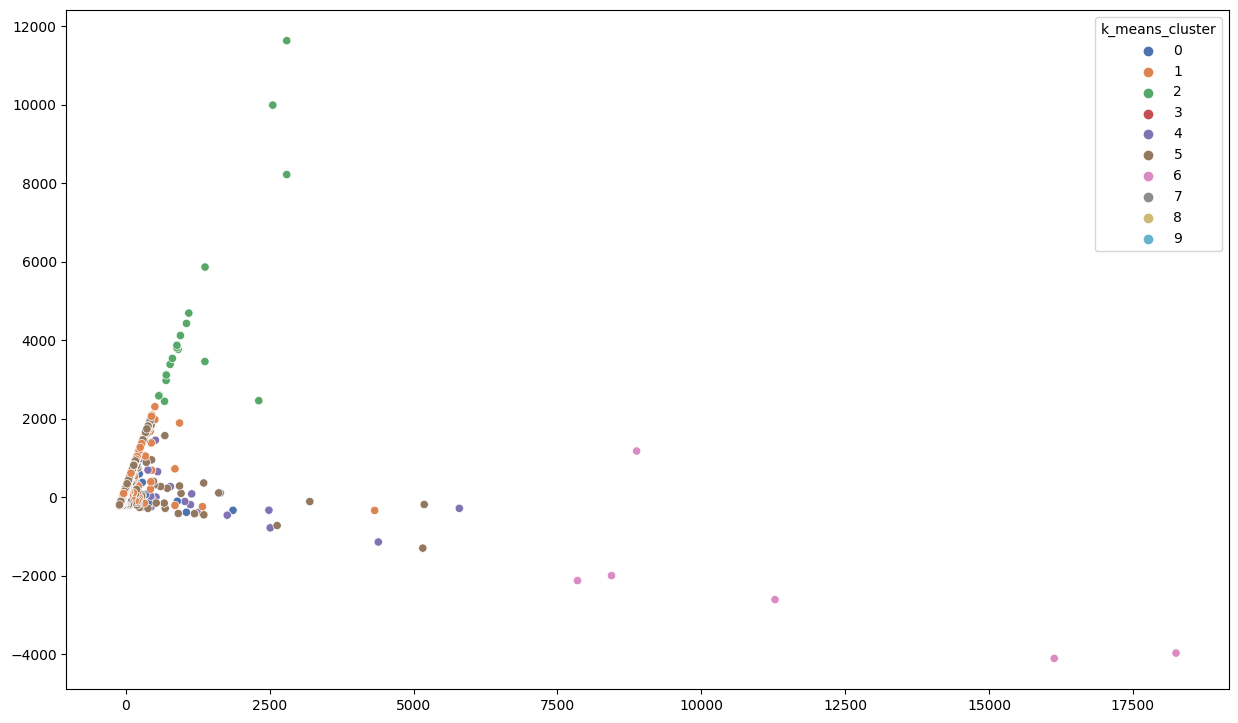

In [7]:
pca = PCA(n_components=2)
pca_vals = pca.fit_transform(investor_summary_df)

sns.scatterplot(x=pca_vals[:,0],y=pca_vals[:,1],hue=investor_summary_df["k_means_cluster"],palette="deep")

In [8]:
investor_clusters = investor_summary_df.groupby("k_means_cluster").mean()
investor_clusters["count"] = investor_summary_df.groupby("k_means_cluster")["k_means_cluster"].count()
investor_clusters

,Gain,DailyGain,ThisWeekGain,RiskScore,MaxDailyRiskScore,MaxMonthlyRiskScore,Copiers,CopyTradesPct,Trades,WinRatio,DailyDD,WeeklyDD,ActiveWeeks,WeeksSinceRegistration,count
k_means_cluster,,,,,,,,,,,,,,,
0,36.217270,-0.724090,-1.443325,4.891820,6.395778,5.282322,15.759894,3.370776,205.952499,67.494736,-4.003245,-5.744473,25.613457,94.302109,758
1,70.151863,-1.274627,-2.125729,5.728814,7.340678,5.872881,24.138983,2.218682,335.659332,67.042839,-7.381559,-10.090593,32.322033,112.406776,590
2,61.933685,-0.706842,-1.184211,4.105263,6.263158,4.947369,186.578949,0.618725,4978.947266,72.350410,-5.745790,-8.261053,51.684212,138.263153,19
3,43.229145,-0.182560,-1.910580,4.020478,5.300341,4.372014,1.303754,82.393578,24.491468,32.267567,-4.584505,-7.000034,45.484642,269.174072,293
4,22.546667,-0.195225,-0.886689,3.547297,5.042793,3.925676,72.159912,6.893830,150.051804,65.294189,-3.011869,-4.383153,36.806305,190.144150,444
5,48.049507,-0.103832,-1.383242,4.137362,6.395605,5.429945,56.342033,6.913731,212.340652,66.429070,-7.463187,-10.853379,53.240383,261.712921,728
6,63.958336,-0.330000,-1.778333,3.833333,6.333333,5.000000,12066.833008,0.000000,837.166687,77.430435,-6.310000,-7.995000,57.000000,211.500000,6
7,54.581520,8.739937,8.138291,6.075949,6.905063,5.500000,3.044304,7.022775,149.734177,66.524773,-7.412722,-9.281709,28.810127,255.911392,158
8,228.933334,-1.776667,158.339996,7.000000,8.000000,4.666667,3.333333,4.761905,29.333334,51.864330,-7.350000,-7.350000,22.666666,143.666672,3


In [10]:
gain_quantile = investor_summary_df['Gain'].quantile(0.5)
risk_quantile = investor_summary_df['MaxMonthlyRiskScore'].quantile(0.5)
win_quantile = investor_summary_df['WinRatio'].quantile(0.5)

best_investors = investor_summary_df[(investor_summary_df['WinRatio']>win_quantile)&
                                     (investor_summary_df['Gain']>gain_quantile)&
                                     (investor_summary_df["MaxMonthlyRiskScore"]<risk_quantile)].copy()

best_investors.sort_values("Gain",ascending=False)

,,Gain,DailyGain,ThisWeekGain,RiskScore,MaxDailyRiskScore,MaxMonthlyRiskScore,Copiers,CopyTradesPct,Trades,WinRatio,DailyDD,WeeklyDD,ActiveWeeks,WeeksSinceRegistration,k_means_cluster
CustomerId,UserName,,,,,,,,,,,,,,,
3125498,SwissInvest4Life,260.640015,-1.07,216.380005,7.0,9.0,2.0,4.0,14.285714,7.0,85.714287,-8.72,-8.72,57.0,385.0,8
14231321,Samosaking,172.850006,0.61,46.400002,3.0,5.0,4.0,174.0,0.000000,91.0,73.626373,-4.34,-6.13,35.0,38.0,4
13459955,Orfanik,116.930000,-1.55,-4.670000,4.0,5.0,4.0,14.0,2.941176,34.0,88.235291,-3.64,-6.67,44.0,47.0,4
9478562,LlLVLIU,91.660004,-1.81,-1.530000,5.0,5.0,4.0,1.0,0.000000,5.0,100.000000,-7.51,-7.51,57.0,144.0,5
14152646,Bamboo108,80.739998,5.53,2.520000,4.0,5.0,4.0,63.0,0.000000,26.0,84.615387,-6.51,-8.80,38.0,39.0,4
12363123,pino428,78.250000,0.20,-1.980000,4.0,6.0,4.0,1629.0,0.000000,723.0,68.188103,-4.06,-5.09,55.0,64.0,4
13911353,Francys1q84,72.529999,0.90,0.360000,5.0,5.0,4.0,4.0,3.236246,309.0,67.637543,-3.25,-3.25,40.0,42.0,4
10383817,Miyoshi,70.370003,0.46,-1.530000,4.0,6.0,3.0,8401.0,0.000000,3489.0,71.940384,-6.12,-6.42,57.0,109.0,6
6007622,Javilanza34,63.029999,3.99,4.690000,3.0,6.0,4.0,1.0,7.058824,85.0,69.411766,-4.63,-5.82,57.0,212.0,4


In [11]:
popular_investors = investor_summary_df[investor_summary_df["Copiers"]>investor_summary_df["Copiers"].quantile(0.99)]
popular_investors.sort_values("Gain",ascending=False)

,,Gain,DailyGain,ThisWeekGain,RiskScore,MaxDailyRiskScore,MaxMonthlyRiskScore,Copiers,CopyTradesPct,Trades,WinRatio,DailyDD,WeeklyDD,ActiveWeeks,WeeksSinceRegistration,k_means_cluster
CustomerId,UserName,,,,,,,,,,,,,,,
12780873,AntoineHaquette,173.250000,1.48,-3.31,5.0,7.0,6.0,1410.0,0.000000,312.0,67.628204,-6.87,-10.03,47.0,56.0,1
6084415,CanZhao,134.119995,-2.64,1.96,4.0,7.0,5.0,3191.0,0.000000,888.0,58.445946,-4.37,-9.88,57.0,208.0,5
9996668,jianswang,108.650002,-2.27,-6.12,5.0,7.0,6.0,4340.0,0.000000,933.0,63.987137,-6.70,-8.07,57.0,125.0,1
10501678,ReturnInvest,102.209999,-1.82,-3.19,5.0,5.0,5.0,5381.0,0.000000,198.0,83.333336,-6.10,-9.27,57.0,105.0,5
13896981,joaoguimaraes10,95.500000,0.66,-4.84,5.0,7.0,6.0,1948.0,0.000000,347.0,65.706055,-4.77,-5.47,42.0,42.0,0
5629087,ChongZheng,91.959999,6.07,3.32,5.0,6.0,5.0,1318.0,0.000000,113.0,75.221237,-9.26,-9.60,57.0,235.0,5
11782013,Prowessinvesting,89.349998,1.06,1.09,4.0,7.0,5.0,1601.0,0.000000,720.0,58.333332,-7.81,-7.81,57.0,77.0,5
5120021,hyjbrighter,80.900002,0.05,-2.04,5.0,8.0,5.0,8733.0,0.000000,304.0,72.368423,-6.59,-9.20,57.0,260.0,6
12363123,pino428,78.250000,0.20,-1.98,4.0,6.0,4.0,1629.0,0.000000,723.0,68.188103,-4.06,-5.09,55.0,64.0,4


# Explore individual stocks

In [12]:
investor_portfolio.head()

,investor_name,date,company,type,invested
0,miyoshi,2021-02-03,SQ,Buying,5.83
1,miyoshi,2021-02-03,ARKF,Buying,4.55
2,miyoshi,2021-02-03,DIS,Buying,4.22
3,miyoshi,2021-02-03,NVDA,Buying,3.65
4,miyoshi,2021-02-03,AMD,Buying,3.35


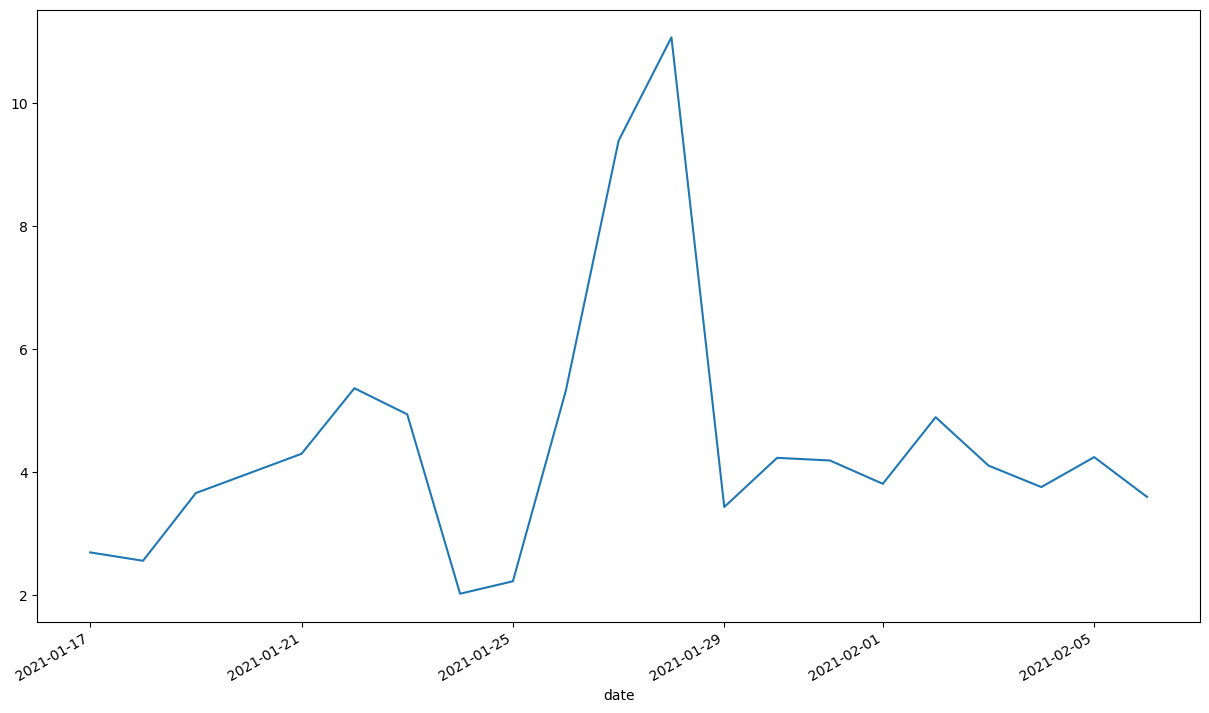

In [13]:
investor_portfolio[investor_portfolio.company=='GME'].groupby('date')['invested'].mean().plot()

In [51]:
dates = sorted(investor_portfolio.date.unique())
len(dates)

20

In [52]:
stocks = investor_portfolio.company.unique()
len(stocks)

2351

In [217]:
best_investor_list = best_investors.reset_index()['UserName'].tolist()

best_investor_stocks = investor_portfolio[investor_portfolio['investor_name'].isin(best_investor_list)]['company'].unique()
print("Stocks of best investors:", len(best_investor_stocks))

Stocks of best investors: 332


In [218]:
groupby = investor_portfolio.groupby(['company','date'])["invested"].mean()
slice_idx = pd.IndexSlice
day_threshold = 10
chg_interest = list()
for stock_name in tqdm(best_investor_stocks):
    last_interest = groupby.to_frame().loc[slice_idx[stock_name, dates[-day_threshold]:], :]
    last_interest_mean = last_interest.mean()

    historical_interest = groupby.to_frame().loc[idx[stock_name, :dates[-day_threshold-1]], :]
    historical_interest_mean = historical_interest.mean()

    vals = groupby.to_frame().loc[stock_name].values.reshape(-1)
    change_in_interest = (last_interest_mean/historical_interest_mean)[0]
    chg_interest.append((stock_name,change_in_interest,historical_interest_mean[0],last_interest_mean[0]))

100%|██████████| 332/332 [00:02<00:00, 162.79it/s]


In [219]:
TOP_N_CHANGE_IN_INTEREST_AMONG_BEST_INVESTORS = 10
chg_intrst = pd.DataFrame.from_records(chg_interest,columns=['stock','change_in_interest',"history","latest"]).sort_values('change_in_interest',ascending=False)
pop_stocks = chg_intrst.head(TOP_N_CHANGE_IN_INTEREST_AMONG_BEST_INVESTORS)
pop_stocks

,stock,change_in_interest,history,latest
88,ZIL2.DE,3.312737,0.916000,3.034467
323,NOKIA.HE,2.302372,1.043583,2.402718
270,HEXO,2.295395,0.633333,1.453750
90,VALE,1.879131,1.560781,2.932911
39,CNK,1.843580,1.456400,2.684989
129,XRP,1.564645,2.253463,3.525869
18,EAT,1.554910,1.147333,1.784000
325,EOAN.DE,1.516341,1.390546,2.108542
252,CORN,1.509967,1.672167,2.524916
38,OLN,1.500975,1.427834,2.143143


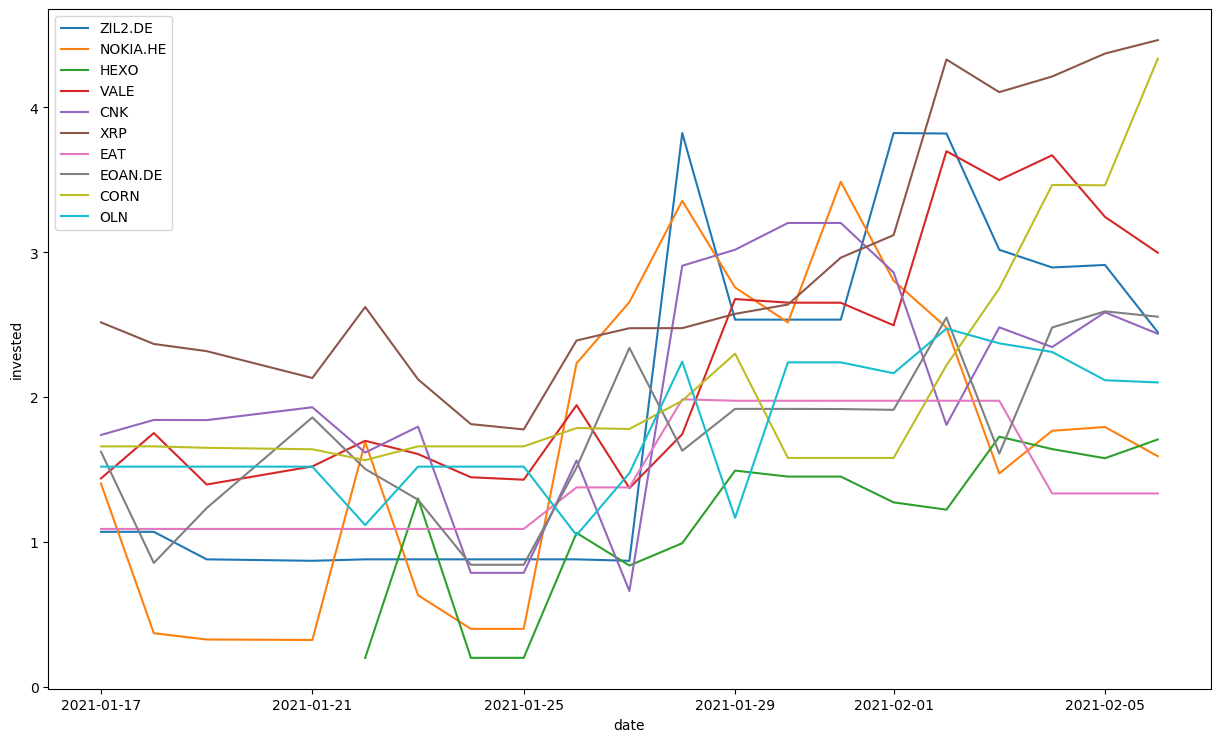

In [220]:
for int_stock in pop_stocks["stock"].values:
    vals = groupby.to_frame().loc[int_stock]
    sns.lineplot(y=vals["invested"],x=vals.index,label=int_stock)

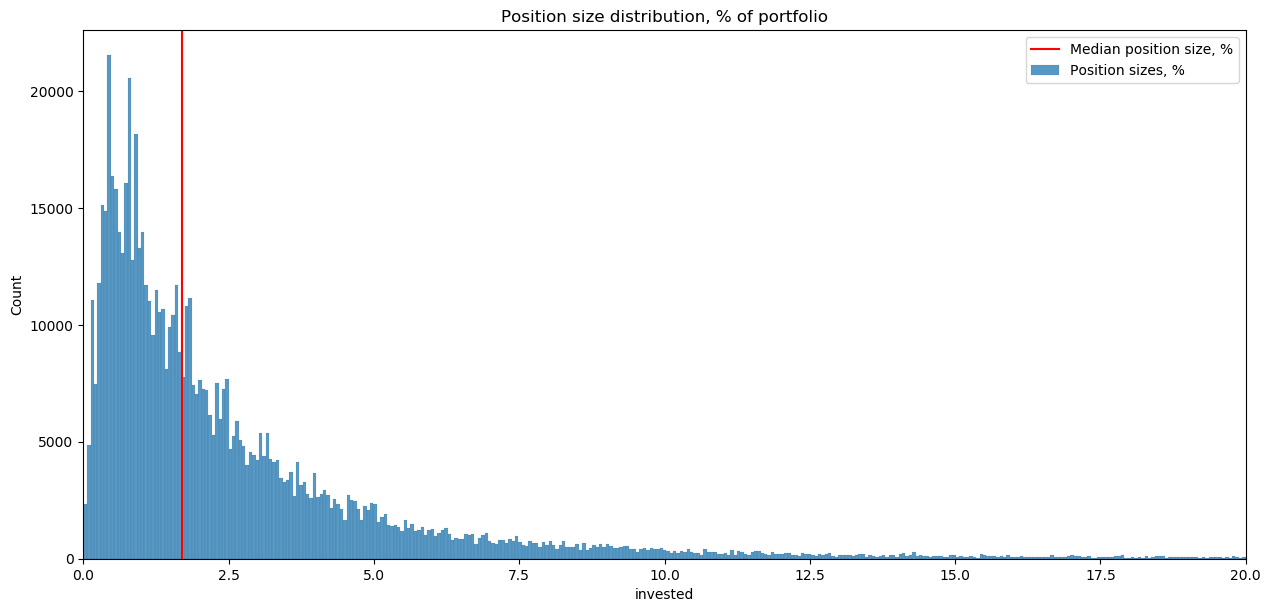

In [221]:
plt.figure(figsize=(15,7))
sns.histplot(investor_portfolio.invested, label='Position sizes, %')
plt.xlim(0,20)
plt.title("Position size distribution, % of portfolio")
plt.axvline(x=investor_portfolio.invested.median(),color='red',label='Median position size, %')
plt.legend()

In [222]:
df_marketbeat_ranks = load_marketbeat()
mb_dates = sorted(df_marketbeat_ranks.date.unique())
marketbeat_latest_date = mb_dates[-1]
df_marketbeat_ranks = df_marketbeat_ranks[df_marketbeat_ranks.date==marketbeat_latest_date].sort_values("valuation_rank",ascending=False)
df_marketbeat_ranks = df_marketbeat_ranks.set_index(["date","symbol"])
df_marketbeat_ranks.sort_values("overall_rank",ascending=False)

overall_rank  insider_rank  community_rank  valuation_rank  \
date       symbol                                                               
2021-02-06 AIZ             3.03           3.3             2.0             3.1   
           ABBV            3.01           1.7             2.9             3.1   
           C               2.93           1.7             3.4             3.8   
           NOC             2.90           1.7             2.4             1.9   
           ZION            2.87           1.7             2.1             3.1   
...                         ...           ...             ...             ...   
           NTCO            0.13           0.0             0.0             0.6   
           LTRPB           0.13           0.0             0.0             0.6   
           IPOF            0.00           0.0             0.0             0.0   
           BUR             0.00           0.0             0.0             0.0   
           NYSE           -1.00           NaN             NaN             NaN   

                   dividend_rank  analyst_rank  
date       symbol                               
2021-02-06 AIZ               4.2           2.5  
           ABBV              5.0           2.4  
           C                 2.5           3.3  
           NOC               4.2           4.4  
           ZION              3.3           4.1  
...                          ...           ...  
           NTCO              0.0           0.0  
           LTRPB             0.0           0.0  
           IPOF              0.0           0.0  
           BUR               0.0           0.0  
           NYSE              NaN           NaN  

[2000 rows x 6 columns]

In [223]:
df_marketbeat_targets = load_marketbeat_target()
df_marketbeat_targets = df_marketbeat_targets[df_marketbeat_targets.date==marketbeat_latest_date]
df_marketbeat_targets["delta"] = df_marketbeat_targets["ConsensusPriceTarget"]/df_marketbeat_targets["SharePrice"]
df_marketbeat_targets = df_marketbeat_targets.set_index(["date","symbol"])
df_marketbeat_targets.sort_values("delta",ascending=False)

ConsensusPriceTarget  MinPriceTarget  MaxPriceTarget  \
date       symbol                                                         
2021-02-06 ORBC                  194.25            10.0            10.0   
           SJ                     56.00            56.0            56.0   
           TXMD                    7.55             4.0             4.0   
           OPTN                   19.00            17.0            19.0   
           ATHX                    9.00             5.0             5.0   
...                                 ...             ...             ...   
           FOSL                    3.75             2.5             2.5   
           EH                     14.00            14.0            14.0   
           FUTU                   17.90            17.9            17.9   
           BLNK                    5.00             5.0             5.0   
           OAS                     1.70             3.5             3.5   

                   SharePrice Currency      delta  
date       symbol                                  
2021-02-06 ORBC      8.240625        $  23.572241  
           SJ        9.106906        $   6.149179  
           TXMD      1.631875        $   4.626580  
           OPTN      4.171875        $   4.554307  
           ATHX      2.160938        $   4.164859  
...                       ...      ...        ...  
           FOSL     13.905313        $   0.269681  
           EH       77.628750        $   0.180346  
           FUTU    104.325000        $   0.171579  
           BLNK     49.715000        $   0.100573  
           OAS      39.472500        $   0.043068  

[1690 rows x 6 columns]

In [224]:
marketbeat_df = df_marketbeat_ranks.join(df_marketbeat_targets,how="outer").sort_values("community_rank",ascending=False)
marketbeat_df.loc[slice_idx[:, pop_stocks["stock"]], :]

overall_rank  insider_rank  community_rank  valuation_rank  \
date       symbol                                                               
2021-02-06 VALE            1.69           0.0             2.2             3.1   
           CNK             1.47           1.7             2.8             0.6   
           EAT             1.63           1.7             2.3             1.9   
           OLN             1.50           1.7             2.2             0.6   

                   dividend_rank  analyst_rank  ConsensusPriceTarget  \
date       symbol                                                      
2021-02-06 VALE              1.7           1.5                   NaN   
           CNK               0.0           2.3                   NaN   
           EAT               0.0           2.3                   NaN   
           OLN               0.8           2.2                   NaN   

                   MinPriceTarget  MaxPriceTarget  SharePrice Currency  delta  
date       symbol                                                              
2021-02-06 VALE               NaN             NaN         NaN      NaN    NaN  
           CNK                NaN             NaN         NaN      NaN    NaN  
           EAT                NaN             NaN         NaN      NaN    NaN  
           OLN                NaN             NaN         NaN      NaN    NaN

In [225]:
marketwatch_df = load_marketwatch()
marketwatch_df = marketwatch_df[marketwatch_df.date==marketbeat_latest_date]
marketwatch_df = marketwatch_df.set_index(["date","symbol"])
marketwatch_df["delta"] = marketwatch_df["Median"]/marketwatch_df["Current Price"]
marketwatch_df.loc[idx[:, pop_stocks["stock"]], :]

Average Recommendation Average Target Price  \
date       symbol                                               
2021-02-06 VALE                      Buy                21.04   
           CNK                Overweight                17.83   
           EAT                Overweight                65.52   
           OLN                Overweight                28.64   

                  Number Of Ratings FY Report Date Last Quarter's Earnings  \
date       symbol                                                            
2021-02-06 VALE                  22        12/2020                    0.57   
           CNK                   12        12/2020                   -1.25   
           EAT                   24         6/2021                    0.35   
           OLN                   15        12/2021                   -0.10   

                  Year Ago Earnings Current Quarter's Estimate  \
date       symbol                                                
2021-02-06 VALE                0.85                       0.91   
           CNK                 1.86                      -1.45   
           EAT                 1.13                       0.78   
           OLN                -1.24                       0.29   

                  Current Year's Estimate Median PE on CY Estimate  \
date       symbol                                                    
2021-02-06 VALE                      1.87                      N/A   
           CNK                      -4.62                      N/A   
           EAT                       2.55                      N/A   
           OLN                       1.01                      N/A   

                  Next Fiscal Year Estimate Median PE on Next FY Estimate  \
date       symbol                                                           
2021-02-06 VALE                        3.43                           N/A   
           CNK                        -2.12                           N/A   
           EAT                         4.26                           N/A   
           OLN                         1.52                           N/A   

                    High  Median   Low  Average  Current Price     delta  
date       symbol                                                         
2021-02-06 VALE    26.08    20.0  16.6    21.04          16.50  1.212121  
           CNK     28.00    16.0  13.0    17.83          20.19  0.792472  
           EAT     80.00    65.0  56.0    65.52          64.65  1.005414  
           OLN     35.00    27.0  25.0    28.64          27.36  0.986842